In [1]:
import shutil
import os
import csv
import time
import math

import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from scipy.stats import pearsonr
import scipy.optimize


import torch
import torch.nn as nn
import torch.nn.functional as F

import boda

import tqdm.notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import seaborn as sns
import arviz as az

mpl.rcParams['pdf.fonttype'] = 42

# Sequence generation
This library focuses on iterative optimization of sequences for cis-regulatory element (CRE) design. There are three components you need to set up a sequence design pipeline:

- `Parameters`: Specify the subject to be optimized. For our manuscript this is typically a `(batch_size, 4, 200)` tensor, representing a 200nt oligo or a distribution over 200nt oligos.
- `Energy`: An objective function accepts an input from `Parameters()` of size (batch_size,...) and yields a 1-D `(batch_size,)` output reflecting the goals of optimization. The convention here is that minimizing energy is the optimization goal.
- `Generator`: An algorithm that accepts a `Parameter` and `Energy` class to generate proposals.

While there is some interchangeability, all combinations of `Parameters`, `Energy`, and `Generator` classes are not valid. The minimal requirements of these classes are reflected in `ParamsBase` and `BaseEnergy` and overall compatibility with `boda2/src/generate.py`. Additionally every `Generator` should have a `.generate()` method that returns a dictionary of `{'samples': [], 'energies':[]}`.

## Load model
Load a model to serve as an oracle for sequence generation. The default in this notebook is to download Malinois from our public GS bucket, but if you can use any model that accepts a 3-dim `(batch_size, 4, 600)` input to produce a 2-dim `(batch_size, n_features)` output. As an alternate example we provide the option to load a model trained using the `construct_new_model.ipynb` tutorial notebook. If you use this alternate, please ensure the model moduels are consistant between the two notebooks.

If you're using models that handle drastically different shapes, you may need to do some work to make sure the Parameters are harmonized with your model inputs.

In [2]:
USE_MAL = True
if USE_MAL:
    malinois_path = 'malinois_artifacts__20211113_021200__287348.tar.gz'
    my_model = boda.common.utils.load_model(malinois_path)
else:
    model_module = boda.model.BassetBranched
    my_model = model_module(
        n_outputs=2, 
        n_linear_layers=1, linear_channels=1000,
        linear_activation='ReLU', linear_dropout_p=0.12, 
        n_branched_layers=3, branched_channels=140, 
        branched_activation='ReLU', branched_dropout_p=0.56, 
        loss_criterion='L1KLmixed', loss_args={'beta':5.0}
    )
    my_model.load_state_dict(torch.load('example_new_model.pt'))

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode


In [3]:
try:
    input_len = torch.load('./artifacts/torch_checkpoint.pt')['model_hparams'].input_len
except:
    input_len = 600

# Fast SeqProp

Fast SeqProp (Fast activation maximization for molecular sequence design by Johannes Linder and Georg Seeling) is an adaptation of the straight through estimator for fixed length, one-hot sequence design. We implment this using the:

- `StraightThroughParameters` parameter class
- `FastSeqProp` generator class

which can be used in combination with many different `Energy` classes.

In [4]:
logits = torch.randn(
    256, 4, 200
)

left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0).expand(logits.shape[0], -1, -1)

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0).expand(logits.shape[0], -1, -1)

params = boda.generator.StraightThroughParameters(
    data=logits, left_flank=left_flank, right_flank=right_flank, 
    n_samples=10, use_affine=False
)
params.cuda()

StraightThroughParameters(
  (norm): InstanceNorm1d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
)

In [5]:
energy = boda.generator.MinGapEnergy(my_model, target_feature=0, a_min=-2., a_max=6.)

In [6]:
FSP = boda.generator.FastSeqProp(energy, params)

## Generate
There are two options to design sequences. 

With `FastSeqProp` you can use the `run` method to optimize the distribution of the straight through estimator parameters stored in `params`. You can then use the `get_sample` method in `StraightThroughParameters` to collect an `(n_samples, batch_size, 4, 600` one-hot tensor that has collected `n_samples` from each optimized distribution.

Alternatively, you can use the `generate` method to repeatedly execute `FastSeqProp` until the desired number of one-hot proposals are collected. At each iteration, the best sample per sequence distribution will be collected to represent that distribution at the end of optimization.

Steps: 100%|███████████████████████████████████████████████████████████████████████████| 200/200 [02:26<00:00,  1.37it/s, Loss=-5.75, LR=1e-6]


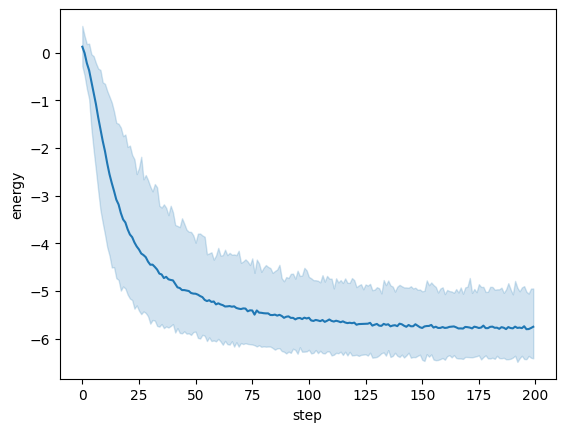

torch.Size([10, 256, 4, 200])

In [7]:
FSP.run(n_steps=200, lr_scheduler=True, create_plot=True)
proposals = params.get_sample()
proposals.shape

In [8]:
proposals = FSP.generate(n_proposals=1000, n_steps=200, lr_scheduler=True)
for k in proposals.keys():
    print(k)
    print(f"\t{proposals[k].shape}")

Steps: 100%|███████████████████████████████████████████████████████████████████████████| 200/200 [02:27<00:00,  1.36it/s, Loss=-5.74, LR=1e-6]


states
	torch.Size([1000, 4, 200])
proposals
	torch.Size([1000, 4, 200])
energies
	torch.Size([1000])
acceptance_rate
	torch.Size([])


# Simulated Annealing

Simulated Annealing is an adaptation of the Metropolis-Hastings MCMC algorithm for non-convex optimization. We implement this by combining the:

- `BasicParameters` parameter class
- `SimulatedAnnealing` generator class

Again, this method can be combined with many different `Energy` classes, but for this example, we're reusing the one from above.

In [9]:
params = boda.generator.BasicParameters(
    data=logits, left_flank=left_flank, right_flank=right_flank
)
params.cuda()

BasicParameters()

In [10]:
SA = boda.generator.SimulatedAnnealing(params, energy, n_positions=3, gamma=0.501)

## Generate
Again, there are two options to design sequences. 

With `SimulatedAnnealing` you can use the `collect_samples` to optimize the batch of sequences housed in `BasicParameters` and return (them with the most recently computed energy values) the trajectory of sequences and energy values. We generate an illustrative plot of the sample trajectory.

Alternatively, you can use the `generate` method in the same way as you would for `FastSeqProp` and will recieve a similarly formatted output.

In [11]:
samples = SA.collect_samples(n_steps=2000, n_burnin=0)

for k in samples['samples'].keys():
    print(k)
    if samples['samples'][k] is not None:
        print(f"\t{samples['samples'][k].shape}")
    else:
        print("\tNone")

collect samples
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:50<00:00, 18.03it/s]


states
	torch.Size([2000, 256, 4, 200])
energies
	torch.Size([2000, 256])
acceptances
	torch.Size([2000, 256])


In [12]:
A_col = (12, 128, 64)
C_col = (56, 83, 164)
G_col = (251, 177, 22)
T_col = (237, 31, 36)
nt_col = np.array([A_col, C_col, G_col, T_col])

36


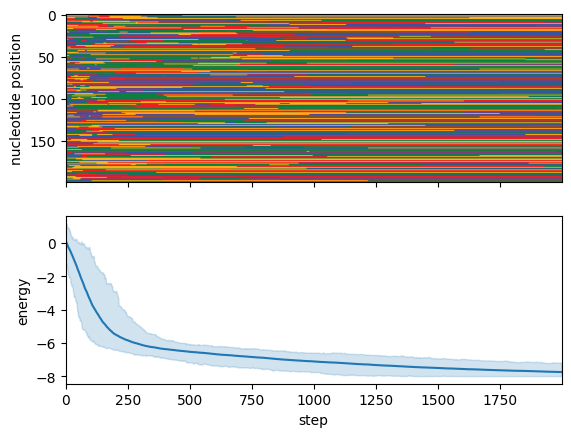

In [13]:
fig, ax = plt.subplots(2,1,sharex=True)

seq_idx = np.random.choice(np.arange(256))
print(seq_idx)
ax[0].imshow(
    np.concatenate(
        [
            nt_col[samples['samples']['states'][:,seq_idx,:,:].max(dim=1).indices]/255.,
            #F.softmax(torch.tensor(FSP.param_hist[:,seq_idx,:,:]),dim=1).max(dim=1).values[:,:,np.newaxis]
        ],
        axis=-1
    ).transpose(1,0,2)
    
)
ax[0].set_aspect('auto')
ax[0].set_ylabel('nucleotide position')

sns.lineplot(
    data=pd.DataFrame(
    {'energy': samples['samples']['energies'].flatten(),
    'step': np.repeat(np.arange(2000), 256)}
    ), 
    x='step',
    y='energy',
    errorbar="pi",
    ax=ax[1]
)


plt.show()

In [14]:
samples = SA.generate(n_proposals=1000, n_steps=2000, n_burnin=0)

for k in samples.keys():
    print(k)
    print(f"\t{samples[k].shape}")


collect samples
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:48<00:00, 18.43it/s]
collect samples


attempt 1 acceptance rate: 256/256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:49<00:00, 18.32it/s]
collect samples


attempt 2 acceptance rate: 256/256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:49<00:00, 18.26it/s]
collect samples


attempt 3 acceptance rate: 256/256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:48<00:00, 18.41it/s]


attempt 4 acceptance rate: 256/256
proposals
	torch.Size([1000, 4, 200])
energies
	torch.Size([1000])
acceptance_rate
	torch.Size([0])


# AdaLead
AdaLead is taken from [Sinai et al.](
https://doi.org/10.48550/arXiv.2010.02141) and is an evolutionary search algorithm. We implement this by combining the:

- PassThroughParameters parameter class
- AdaLead generator class

We're again reusing the energy class from above, but this time we're changing the batch size by updating the`logits` tensor.

In [15]:
batch_size = 64

logits = torch.randn(batch_size, 4, 200)

left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)


params = boda.generator.parameters.PassThroughParameters(
            data=logits, left_flank=left_flank, right_flank=right_flank, token_dim=1
        ).cuda()
     
AL = boda.generator.AdaLead(energy, params)

results = AL.generate(
    n_proposals=5, n_steps=30, rho=2, threshold=0.05, mu=1, 
    energy_threshold=-2, recomb_rate=0.1, n_top_seqs_per_batch=1, 
    model_queries_per_batch=10*batch_size,max_attempts=1000
)

At least 5 batches are needed to propose 5 sequences
Make sure max_attempts >= 5



Batch 5 (4/5 proposals generated ): 100%|███████████████████████████████████████████████| 30/30 [00:08<00:00,  3.66it/s, Batch mean fitness=8]


5 proposals generated


In [16]:
for k in results.keys():
    print(k)
    print(f"\t{results[k].shape}")


proposals
	torch.Size([5, 4, 200])
energies
	torch.Size([5])
acceptance_rate
	()


# Zero-order Markov sampling

Zero-order Markov sampling samples strings with a fixed probablility and retains a collection of the lowest energy elements that have been tested so far. Make sure n_proposals < logits.shape[0] * n_steps otherwise you won't collect enough samples to satify the n_proposals request. We implement this for the uniform case by combining the:

- `PassThroughParameters` parameter class
- `ZeroOrderMarkov` generator class

Like the others, this method can be combined with many different `Energy` classes, but for this example, we're reusing the one from above.

In [17]:
params = boda.generator.parameters.PassThroughParameters(
    data=logits, left_flank=left_flank, right_flank=right_flank, token_dim=1
).cuda()

In [18]:
ZOM = boda.generator.ZeroOrderMarkov(params, energy)

## Generate
For this algorithm, there's only one option to design sequences. 

Use the `generate` method to get a dictionary of `{'samples': torch.tensor, 'energies': torch.tensor}`.

In [19]:
n_steps = 10000
log_step= 10
zom_samples = ZOM.generate(n_proposals=1000, n_steps=n_steps, log_energy=True, log_step=log_step)


Steps: 100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:26<00:00, 115.94it/s, energy=-2.86]


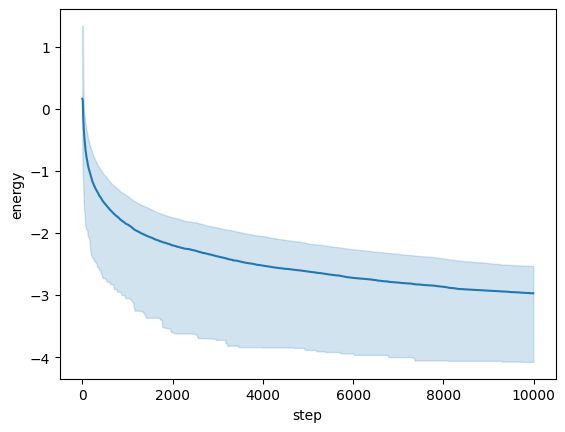

In [20]:
fig, ax = plt.subplots(1,1)

timer = 'step'

sns.lineplot(data=ZOM.energy_log, x=timer, y="energy", errorbar="pi", ax=ax)

plt.show()

In [21]:
for k in zom_samples.keys():
    print(k)
    print(f"\t{zom_samples[k].shape}")


proposals
	torch.Size([1000, 4, 200])
energies
	torch.Size([1000])
